# Imports

In [ ]:
# Imports 

# General imports
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt

# Pytorch and transformers (for LLM)
import transformers, torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline, AutoModel
transformers.logging.set_verbosity_info()

# For loading documents from a path
from pathlib import Path

# For the embedding module
from sentence_transformers import SentenceTransformer

# %%

# Load device

if torch.backends.mps.is_available():
    # MPS is the GPU model in Mac technology
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device =torch.device("cpu")

print (torch.ones(1, device=device))

# The different Modules of the RAG

## The foundation model

We are going to work with Foundation Models, that is models that have been pre-trained on large data sets; but we want to work with OpenSource and hosted models. To do so we are going to fetch models from the [HuggingFace plateform](https://huggingface.co/)

In [ ]:
class FoundationModel():

    def __init__(self,FOUND_MODEL_PATH,TEMPERATURE=None,MAX_NEW_TOKENS=10000):
        
        self.model=AutoModelForCausalLM.from_pretrained(FOUND_MODEL_PATH, 
                                             #device_map=mps_device,
                                             #device_map=cuda,
                                             torch_dtype="auto",
                                             trust_remote_code=True,
                                             ).to(device)
        
        
        self.tokenizer= AutoTokenizer.from_pretrained(FOUND_MODEL_PATH)

        self.model.generation_config.temperature=TEMPERATURE # Config of the temperature
        self.model.generation_config.top_p=None              # Config parameter related to the type of generation (like greedy decoding for instance)

        self.llm = pipeline("text-generation",
                     model=self.model,
                     tokenizer=self.tokenizer,
                     return_full_text=False,
                     max_new_tokens=MAX_NEW_TOKENS,
                     do_sample=True
                     )
        
        self.num_parameters = self.model.num_parameters()
        
        print('Number of parameters in my model','{:.2e}'.format(self.num_parameters))


    def generate_response(self,prompt):
        
        messages = [
            {'role':'user', 'content':prompt}
            ]
        
        output=self.llm(messages)
        # Note that the output is a list of len 1 which is a dict with key 'generated_text'
        return output


    # We anticipate the use of RAG and create a generate response taking into account the context

    def generate_response_with_context(self, prompt, context):
    
        # The context is a list of str 
    
        messages = []

        if context:
            for i, ctx in enumerate(context):
                messages.append({'role': 'system','content': f"context {i+1}: {ctx}"})

        messages.append({'role': 'user', 'content': prompt})

    
        output=self.llm(messages)
        return output
    
# Some format printing functions

def extract_response(output):
    # output is a list of len 1 as a dict with key 'generated_text'

    return output[0]['generated_text']

def short_response(output):

    response=extract_response(output=output)
    #text = "Before <think>to delete</think> After"
    short = re.sub(r"<think>.*?</think>", "", response, flags=re.DOTALL)
    return short.strip()

# Some foundation models

Path_SDS="HuggingFaceTB/SmolLM3-3B"
Path_Qwen_4B = "Qwen/Qwen3-4B"
Path_DSR1="deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"
Path_Q_06="Qwen/Qwen3-0.6B"

# Ex of call
#f_model = FoundationModel(FOUND_MODEL_PATH=Path_Q_06)


## The Embedding model

Our foundation model will be mostly used as a decoder, even though it includes an encoder one usually chooses a separate embedding model. Indeed the embedding model of the decoder is designed for the generation process but fails to produce most adequate embeddings for a semantic study (like computing similarity). We make use here of an Open Source embedding model from Library `SentenceTransformer` (in particular we will create embeddings for sentences or more precisely for *chunks*).

In [ ]:
class EmbeddingModel():

    def __init__(self,EMBEDD_MODEL_PATH):
        
        # EMBEDD_MODEL_PATH is the name of the embedding model used within the SentenceTransformer lib

        self.Embedmodel=SentenceTransformer(EMBEDD_MODEL_PATH).to(device)
        self.dim=SentenceTransformer(EMBEDD_MODEL_PATH).get_sentence_embedding_dimension()


    def get_embeddings(self,texts):
        
        # texts is a list of strings (which is supposed to be the list of chinks; without the source)
        # we return embeddings of torch type with shape (len(texts),self.dim)

        embeddings=self.Embedmodel.encode(texts,convert_to_tensor=True,normalize_embeddings=True).to(device)
        return embeddings
    

    def compute_cos_sim_embed(self,embed1,embed2):

        # embed1,embeds2 are two embeddings of shape (1,dim)
        # We compute the cos-similarity of two texts (it is returned as a float)

        embed1=embed1.view(-1)
        embed2=embed2.view(-1)

        norm1=torch.norm(embed1,p=2,dim=0)
        norm2=torch.norm(embed2,p=2,dim=0)

        scal = torch.dot(embed1,embed2)
        
        return scal.item()/(norm1.item()*norm2.item())

    
    def compute_cos_sim_texts(self,text_1,text_2):

        # text1,text2 are two str
        # We compute the cos-similarity of two texts (it is returned as a float)

        embeds = self.get_embeddings(texts=[text_1,text_2])
        
        return self.compute_cos_sim_embed(embeds[0],embeds[1])
    

# An embedding model

Embed_mini="all-MiniLM-L6-v2"

# Ex of call
# EmbedModel=EmbeddingModel(EMBEDD_MODEL_PATH=Embed_mini)


## Notion of Chunk and Splitter

We decide to create a class for managing chunks. A *chunk* will be defined by:

-  ```source``` the name of the .txt file from which the chunk comes from
-  ```content``` which is the str that composes the chunk
-  ```embedding``` which is the embedding associated to ```content```.

In [ ]:
class Chunk():

    def __init__(self,source,content,embed_model: EmbeddingModel):

        self.embedding_model=embed_model

        #dim is the common dimension of the embeddings
        dim = self.embedding_model.dim
        
        # A chunk is defined by its source (str); its content (str); its embedding (a torch which shape (1,dim))

        self.source=str(source)
        self.content=str(content)
        self.embedding=self.embedding_model.get_embeddings(texts=[content]).reshape(1,dim)


    def print_chunk(self):

        print('source:',self.source,'content:',self.content,'embedding shape:',self.embedding.shape)

## Todwards the index: the splitter

We are going to chunk resources and then compare the similarity of each of these chunks with the one of the query. We follow the plan of the lecture and start with the splitter.

This class aims in getting the documents that will be in a folder with address ```path_doc```, and return as an output of the method ```get_chunks``` the chunks associated to these resources. Note that we keep track of which document is issued each chunk (via the ```source``` feature).

In [ ]:
class Splitter():

    def __init__(self,embed_model: EmbeddingModel):
        
        self.embedding_model=embed_model
        
        self.docs = [] 
        # We store the original documents as a list of .txt files (format is {"source":'File_name',"content_page":(str)})
        self.chunks=[] 
        # This will be the list of chunks 

    def get_documents(self,path_doc):
        # PATH_DOC is the Path form where the documents will be found (each document is a.txt file).
        docs=[]

        for file in Path(path_doc).rglob("*.txt"):
            name=file.name
            with open(file, "r", encoding="utf-8") as file: 
                resource=file.read().strip()
                if resource:
                    #print(resource,len(resource))
                    docs.append({"source":name,"content_page":resource})
        
        self.docs=docs


    def get_chunks_contents_from_1_doc(self,file_name,content_page,chunk_size,overlap,sentence_split=False):

        if chunk_size < overlap:
            raise Exception('Careful overlap must be smaller than chunk_size')
        
        # Now we chunk according to chunk size and overlap

        if sentence_split:

            content=content_page.split(".")

            for text in content:

                text = text.lstrip()

                if not text=="":
                    self.chunks.append(Chunk(source=file_name,
                      content=text,embed_model=self.embedding_model))
        
        else:
        
            current = 0

            while current < len(content_page):
                end = min(len(content_page),current+chunk_size)
                content = content_page[current:end]
            
                self.chunks.append(Chunk(source=file_name,
                      content=content,embed_model=self.embedding_model))
                
                current += chunk_size - overlap
        

    def get_chunks(self,path_doc,chunk_size,overlap,sentence_split=False):

        self.get_documents(path_doc=path_doc)

        docs=self.docs

        for doc in docs:

            self.get_chunks_contents_from_1_doc(file_name=doc["source"],
                                                content_page=doc["content_page"],
                                                chunk_size=chunk_size,
                                                overlap=overlap,
                                                sentence_split=sentence_split)
    
    def reset_splitter(self):

        self.docs=[]
        self.chunks=[]


## Index, Database and Retriever

We are now in position to define the retriever. In our setting with very few document we will build our index (when the number of resources is pretty high (over $10^4$) we make use of an index (which is trained for that purpose); one can for example make use of the FAISS library.

In [ ]:
class Retriever():

    def __init__(self,embed_model: EmbeddingModel):
        
        self.embedding_model=embed_model
        
        # The index is a list of (Id(int),chunk); chunk needs the size DIM for the Embeddings
        self.index=[]
        
        
    def add_elements_to_index(self,chunks):

        # chunks is a list of chunk

        num = len(self.index)

        for chunk in chunks:

            self.index.append([num,chunk])
            num+=1

    def search_best(self,query,number_of_hits=3,adapt=False):
        
        # query is a str

        query_embed = self.embedding_model.get_embeddings(texts=[query]).to(device).reshape(1,self.embedding_model.dim)

        results=[]

        index=self.index

        scores=[]

        for item in index:

            id,chunk = item

            sim = self.embedding_model.compute_cos_sim_embed(embed1=query_embed,embed2=chunk.embedding)

            scores.append((id,chunk,sim))
  
        results=sorted(scores,key=lambda x:x[2],reverse=True)[:min(number_of_hits,len(index))]

        # We can also add a criterion to exclude the worst hits; here we choose an arbitrary criterion (we exclude a hit if the similarity is smaller than half of the previous one among the number_of_hits chunks)

        if adapt:

            i=1
            go=True
            while go and i<len(results):
                if results[i][2] < results[i-1][2]*0.5:
                    go=False
                else:
                    i+=1
            
            results=results[:i]

        return results
    
    def reset_Retriever_index(self):

        self.index=[]

# The RAG Architecture

In [ ]:
class RAG():

    def __init__(self,CONFIG):
        
        self.foundation_model=FoundationModel(FOUND_MODEL_PATH=CONFIG['FOUND_MODEL_PATH'])
        self.Embedding_model=EmbeddingModel(EMBEDD_MODEL_PATH=CONFIG['EMBEDD_MODEL_PATH'])
        self.splitter=Splitter(self.Embedding_model)
        self.retriever=Retriever(self.Embedding_model)

        self.dim_embed = CONFIG['DIM_EMBED']
        self.chunk_size = CONFIG['CHUNK_SIZE']
        self.overlap = CONFIG['OVERLAP']

    
    def reset_index(self):

        self.retriever.reset_Retriever_index()
        self.splitter.reset_splitter()
    
    
    def load_documents_and_get_chunks(self,path,sentence_split=False):

        self.splitter.get_chunks(path_doc=path,
                                 chunk_size=self.chunk_size,
                                 overlap=self.overlap,
                                 sentence_split=sentence_split)
        
        chunks = self.splitter.chunks

        self.retriever.add_elements_to_index(chunks=chunks)
        
    
    def get_retrieval(self,query,number_of_hits,adapt=False):

        retrieved_info = self.retriever.search_best(query=query,number_of_hits=number_of_hits,adapt=adapt)

        # It is the full information of the form (Id, chunk, sim)

        retrieved=[]
        
        for elem in retrieved_info:

            i,chunk, distance=elem

            retrieved.append(chunk.content)
        
        # We get rid of repeated items
        return list(dict.fromkeys(retrieved))
    
    def generate_response_rag(self,query):

        retrieved=self.get_retrieval(query=query,
                                          number_of_hits=3)
        
        return self.foundation_model.generate_response_with_context(prompt=query,
                                                                   context=retrieved)


# Quantitative LLM evaluation in a nutshell

## Q&A task; definition of `query`, `retrieved_context`, `expected_response` and `response` 

In [ ]:
CONFIG = {
    'FOUND_MODEL_PATH':Path_Q_06,
    #'FOUND_MODEL_PATH':"Qwen/Qwen3-4B",
    'EMBEDD_MODEL_PATH':"all-MiniLM-L6-v2",
    'DIM_EMBED':384,
    'CHUNK_SIZE':300,
    'OVERLAP':30
        }

rag = RAG(CONFIG=CONFIG)

In [ ]:
# We work with the personalities file

queries = [
"Who introduced the theory of relativity?",
"Who was the first computer programmer?",
"What did Isaac Newton contribute to science?",
"Who won two Nobel Prizes for research on radioactivity?",
"What is the theory of evolution by natural selection?"
]

print(queries)


expected_responses = [
"Albert Einstein proposed the theory of relativity, which transformed our understanding of time, space and gravity.",
"Ada Lovelace is regarded as the first computer programmer for her work on Charles Babbage's early mechanical computer, the Analytical Engine.",
"Isaac Newton formulated the laws of motion and universal gravitation, laying the foundation for classical mechanics.",
"Marie Curie was a physicist and chemist who conducted pioneering research on radioactivity and won two Nobel Prizes.",
"Charles Darwin introduced the theory of evolution by natural selection in his book 'On the Origin of Species'."
]

print(expected_responses)

In [ ]:
# We initialize our RAG with our documents

rag.reset_index()

rag.load_documents_and_get_chunks(path=Path.cwd()/"Docs",sentence_split=True)

chunks=rag.splitter.chunks

In [ ]:
# We get the retrieved context; here it is important to let the number of hits to be chosen by the model

retrieved_contexts=[rag.get_retrieval(query=q,number_of_hits=3,adapt=True) for q in queries]

print(retrieved_contexts)

In [ ]:
responses = [short_response(rag.foundation_model.generate_response_with_context(prompt=query,context=retrieved_contexts)) for query in queries]

print(responses)

So naturally the first notion of evaluation and the less objective is human evaluation. We would like to introduce more quantitative indicators.

## Similarity evaluation functions

In [ ]:
# We first can simply compute similarities between 2 of the 3 elements Q, ER, RC.

def similarity_resp_expect(response, expected_responses):
    # response is a single str
    # expected_responses is the list of all expected_responses
    return [rag.Embedding_model.compute_cos_sim_texts(response,expected_response) for expected_response in expected_responses]

def similarity_resp_context(response, contexts):
    # response is a single str
    # contexts is the list of all retrieved contexts (if there are several sentence retrieved for a given query then they are concatenated)
    return [rag.Embedding_model.compute_cos_sim_texts(response,"".join(context)) for context in contexts]

def similarity_resp_query(response, query):
    # response is a single str
    return rag.Embedding_model.compute_cos_sim_texts(response,query) 


def evaluate_sim(query,expected_responses,response,contexts):
    
    l=[-1]*len(expected_responses)
    l[0]=similarity_resp_query(response, query)

    return {
        "Similarity resp. expected_response": similarity_resp_expect(response, expected_responses),
        "Similarity resp. contexts": similarity_resp_context(response, contexts),
        "Similarity resp. query": l,
    }

In [ ]:
# We test for the first query for example

sim = evaluate_sim(query=queries[0],expected_responses=expected_responses,response=responses[0],contexts=retrieved_contexts)
print(sim)

dfsim=pd.DataFrame(sim)

print(dfsim)

In [ ]:
# One can go further and try to go beyond the similarity by defining indicators for the semantic precision
# There are several ways to do so; here we simply give one example which could be related to the so-called 'faithfulness' and which tries to answer the question: "How much the answer is built from the retrieved context?"

def faithfulness_precision(response, retrieved_context, threshold=0.5):
    # Precision = 1 if the response is supported by at least one chunk
    supported = any(rag.Embedding_model.compute_cos_sim_texts(response,chunk) >= threshold for chunk in retrieved_context)
    return 1.0 if supported else 0.0

def faithfulness_recall(response, retrieved_context, threshold=0.5):
    # Recall = proportion of chunks supporting the answer
    if len(retrieved_context) == 0:
        return 0.0
    covered = sum(rag.Embedding_model.compute_cos_sim_texts(response,chunk) >= threshold for chunk in retrieved_context)
    return covered / len(retrieved_context)

def f1_score(precision, recall):
    if precision + recall == 0:
        return 0.0
    return 2 * (precision * recall) / (precision + recall)


def evaluate_faithfulness(response,retrieved_context,threshold=0.5):

    precision=faithfulness_precision(response=response, retrieved_context=retrieved_context, threshold=threshold)
    recall=faithfulness_recall(response, retrieved_context=retrieved_context, threshold=threshold)

    return {
        "Faithfulness precision": precision,
        "Faithfulness recall": recall,
        "Faithfullness F1": f1_score(precision=precision, recall=recall),
    }

In [ ]:
# We test for the first query for example

print(retrieved_contexts[0],len(retrieved_contexts[0]))

faithfulness = evaluate_faithfulness(response=responses[0],retrieved_context=retrieved_contexts[0])
print(faithfulness)


Test these functions on the different queries above. Note that the queries and references are pretty different from each others; though finding the relevant `retrieved_context`might be challenging.

### To go further: the Brief History of Time and Interstellar Q&A RAG

To go further one may consider the task related to documents which are even closer from the semantic point of view and consider the files BHT.txt and Interstellar.txt in the Docs2 folder. These two files are long extracts of two Wikipedia pages: one dedicated to the Interstellar movie and the other one to the documentary on Stephen Hawkins' life. 

In [ ]:
# We initialize our RAG with our documents

rag.reset_index()

rag.load_documents_and_get_chunks(path=Path.cwd()/"Docs2",sentence_split=True)

chunks=rag.splitter.chunks

In [ ]:
queries = ["How was the income for the Nolan's movie?",
"Who was the main caracter of the biographical documentary?",
"How is the science in both movies?"
]
expected_responses =["""Interstellar raised $677 million as a direct income and $773 million with subsequent re-releases), making it the tenth-highest grossing film of 2014""",
"The documentary tells the story of the famous physicist Stephen Hawkins",
"""The science is well documented in both movies. In Interstellar, Caltech theoretical physicist and 2017 Nobel laureate in Physics[4]
Kip Thorne was an executive producer, acted as a scientific consultant, and wrote a tie-in book, The Science of Interstellar. It has
also received praise from many astronomers for its scientific accuracy and portrayal of theoretical astrophysics.Since its premiere,
Interstellar gained a cult following,[5] and now is regarded by many sci-fi experts as one of the best science-fiction films of all
time. For Hawking life it is based on his bestseller book and Morris has studied the history and philosophy of science at Princeton
and later Berkeley."""
]

In [ ]:
retrieved_contexts=[rag.get_retrieval(query=q,number_of_hits=3,adapt=True) for q in queries]

for r in retrieved_contexts:
    print(len(r))

responses = [short_response(rag.foundation_model.generate_response_with_context(prompt=query,context=retrieved_contexts)) for query in queries]

for r in responses:
    print(r,"\n")

Inspired from the methods above, proceed to the evaluation:

- Human evaluation of the answers (one can inspect the complete answer)
- Discuss the chunking strategy, what about the context length ? the overlapping ? 

## Evaluation methods with llm as a judge

The previous example showed how the search of relevant chunks is difficult and how important it might be on the result. Other methods involving llm have been developed we simply mention them and refer for instance to the [RAGAS library](https://docs.ragas.io/en/stable/concepts/metrics/available_metrics/).

# An introduction to multimodal LLM and multimodal retrieval and index search

In [48]:
#!pip install torch torchvision pillow annoy ftfy regex tqdm
#!pip install git+https://github.com/openai/CLIP.git

## Imports

In [49]:
import os
import clip
from PIL import Image
from annoy import AnnoyIndex

### CLIP

#### Visit the CLIP webpage: [CLIP](https://github.com/openai/CLIP?tab=readme-ov-file)

#### Loading the model on a given database

In [51]:
# We load the CLIP model

model, preprocess = clip.load("ViT-B/32", device=device)

In [52]:
# We are going to load and collect the images which are all in subfolders of a root folder 'root_dir' (choose the path where the images of the project are located)

root_dir = Path.cwd()/"Images"
print(root_dir)

image_paths = []
# collects all the paths of subdirectories

for root, dirs, files in os.walk(root_dir):
    print("ROOT:", root)
    print("FILES:", files)
    for file in files:
        if file.lower().endswith((".png", ".jpg", ".jpeg")):
            image_paths.append(os.path.join(root, file))


/Users/reveilla/Documents/Enseignements/2025-2026/AIF/TP_RAG/TP/Images
ROOT: /Users/reveilla/Documents/Enseignements/2025-2026/AIF/TP_RAG/TP/Images
FILES: ['.DS_Store']
ROOT: /Users/reveilla/Documents/Enseignements/2025-2026/AIF/TP_RAG/TP/Images/documentary
FILES: ['44943.jpg', '5914.jpg', '759.jpg', '105163.jpg', '124807.jpg', '99855.jpg', '89501.jpg', '100190.jpg', '2129.jpg', '104309.jpg', '55440.jpg', '60376.jpg', '1185.jpg', '47681.jpg', '93162.jpg', '126961.jpg', '26524.jpg', '74504.jpg', '27835.jpg', '48389.jpg', '77179.jpg', '97933.jpg', '68273.jpg', '602.jpg', '77800.jpg', '54607.jpg', '125908.jpg', '109004.jpg', '111878.jpg', '3386.jpg', '114068.jpg', '90863.jpg', '85275.jpg', '98144.jpg', '110387.jpg', '58610.jpg', '130296.jpg', '103066.jpg', '115176.jpg', '99689.jpg', '119214.jpg', '6203.jpg', '89100.jpg', '4824.jpg', '3226.jpg', '86491.jpg', '58879.jpg', '46065.jpg', '69521.jpg', '4117.jpg', '114186.jpg', '116975.jpg', '128.jpg', '97238.jpg', '108544.jpg', '106972.jpg', '1

In [53]:
# We load the images from root_dir

images = []
for path in image_paths:
    img = preprocess(Image.open(path).convert("RGB"))
    images.append(img)

images = torch.stack(images).to(device)
print(images.shape)

torch.Size([5375, 3, 224, 224])


In [54]:
# We create embeddings for the images

with torch.no_grad():
    image_embeddings = model.encode_image(images)
    image_embeddings = image_embeddings / image_embeddings.norm(dim=1, keepdim=True)

image_embeddings = image_embeddings.cpu().numpy()
print(type(image_embeddings),image_embeddings.shape)


<class 'numpy.ndarray'> (5375, 512)


Getting the embeddings

In [55]:
# Encoding a text

def encode_text(text):
    tokens = clip.tokenize([text]).to(device)
    with torch.no_grad():
        emb = model.encode_text(tokens)
        emb = emb / emb.norm(dim=1, keepdim=True)
    return emb.cpu().numpy()[0]


In [56]:
# Text embedding
text='rugby'
text_emb=encode_text(text)

print(type(text_emb),text_emb.shape)

<class 'numpy.ndarray'> (512,)


In [57]:
# Encoding an image

def encode_image(image_path):
    image=preprocess(Image.open(image_path).convert("RGB")).unsqueeze(0).to(device)

    with torch.no_grad():
        emb = model.encode_image(image)
        emb = emb / emb.norm(dim=1, keepdim=True)
    return emb.cpu().numpy()[0] 

In [58]:
# Image embedding
image_path=image_paths[10]
im_emb=encode_image(image_path=image_path)

print(type(im_emb),im_emb.shape)

<class 'numpy.ndarray'> (512,)


##### Computing cos similarities

In [59]:
def compute_cos_sim(embed1,embed2):

    # embed1,embeds2 are two embeddings; careful they are already normalized
    # We compute the cos-similarity of two texts (it is returned as a float)

    return np.dot(embed1,embed2.T).item()

In [60]:
# Embeddings text-text

print(compute_cos_sim(encode_text('rugby'),encode_text('ball')))
print(compute_cos_sim(encode_text('cat'),encode_text('tiger')))
print(compute_cos_sim(encode_text('cat'),encode_text('book')))

0.82177734375
0.869140625
0.78271484375


0.241455078125
0.1707763671875
0.1802978515625


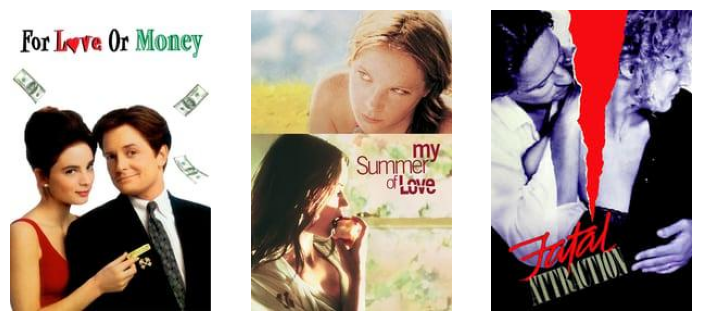

In [61]:
# Embeddings text-image

plt.figure(figsize=(15, 4))
for i in range(525,528):
    image=Image.open(image_paths[i])
    plt.subplot(1, 5, i-525+1)
    plt.imshow(image)
    plt.axis("off")
    print(compute_cos_sim(encode_text('money'),encode_image(image_paths[i])))

plt.show()


**So the similarity can be pretty low, this is usually the case with CLIP; more precise description will improve the result**

0.2783203125
0.2283935546875
0.2125244140625


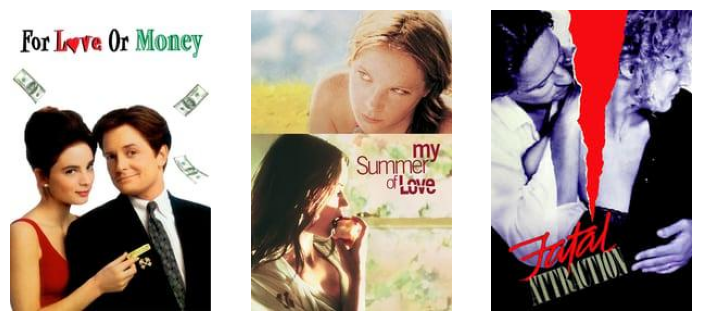

In [62]:
# Embeddings text-image

plt.figure(figsize=(15, 4))
for i in range(525,528):
    image=Image.open(image_paths[i])
    plt.subplot(1, 5, i-525+1)
    plt.imshow(image)
    plt.axis("off")
    print(compute_cos_sim(encode_text('a couple with Love or Money'),encode_image(image_paths[i])))

plt.show()

0.99951171875
0.56396484375
0.5830078125


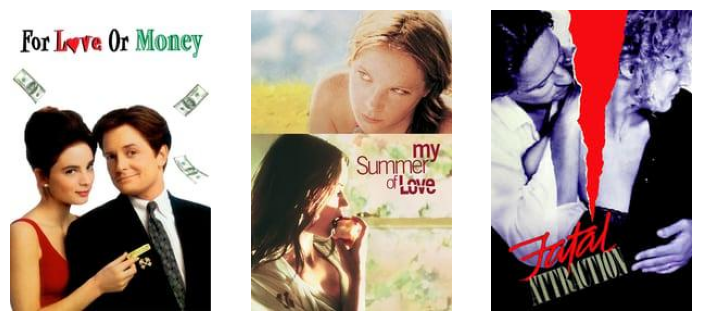

In [63]:
# Embeddings image-image

plt.figure(figsize=(15, 4))
for i in range(525,528):
    image=Image.open(image_paths[i])
    plt.subplot(1, 5, i-525+1)
    plt.imshow(image)
    plt.axis("off")
    print(compute_cos_sim(encode_image(image_paths[525]),encode_image(image_paths[i])))

plt.show()


### Index using ANNOY

#### ANNOY is a search library belonging to the category of trees search based on the values of the embeddings. Visit the webpage: [ANNOY](https://github.com/spotify/annoy) to get a feeling of the architecture of this index. 

In [64]:
dim = image_embeddings.shape[1]
index = AnnoyIndex(dim, metric="angular")

for i, emb in enumerate(image_embeddings):
    index.add_item(i, emb)

# The index search is based on random trees method and one has to initialize the size of the index (20 trees in the example below)
index.build(20)  

True

In [65]:
# Encoding a text

def encode_text(text):
    tokens = clip.tokenize([text]).to(device)
    with torch.no_grad():
        emb = model.encode_text(tokens)
        emb = emb / emb.norm(dim=1, keepdim=True)
    return emb.cpu().numpy()[0]


### Findings best hits from a request

The advantage of a multimodal model is to allow one to make requests either as a text input or an image input (in our examples where the modes are text and image).

##### Finding images from text

Given a text description; we look for the neighboring images.

[2738, 978, 3403, 1552, 3546]


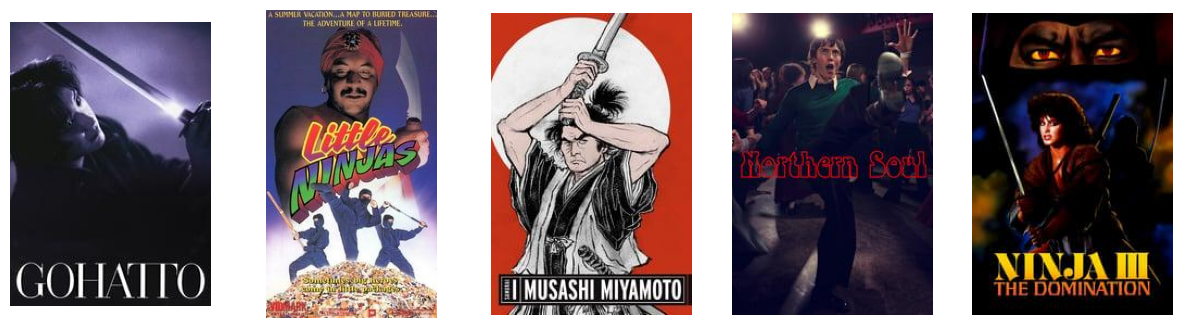

In [66]:
query = "a ninja with a sabre"
query_emb = encode_text(query)

results = index.get_nns_by_vector(query_emb, 5)
print(results)

plt.figure(figsize=(15, 4))
for i, idx in enumerate(results):
    plt.subplot(1, 5, i+1)
    plt.imshow(Image.open(image_paths[idx]))
    plt.axis("off")
plt.show()


#### Finding images from an image

Given an image; we look for the neighboring images.

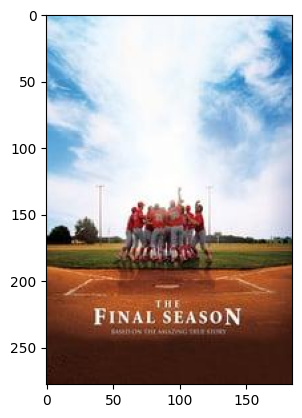

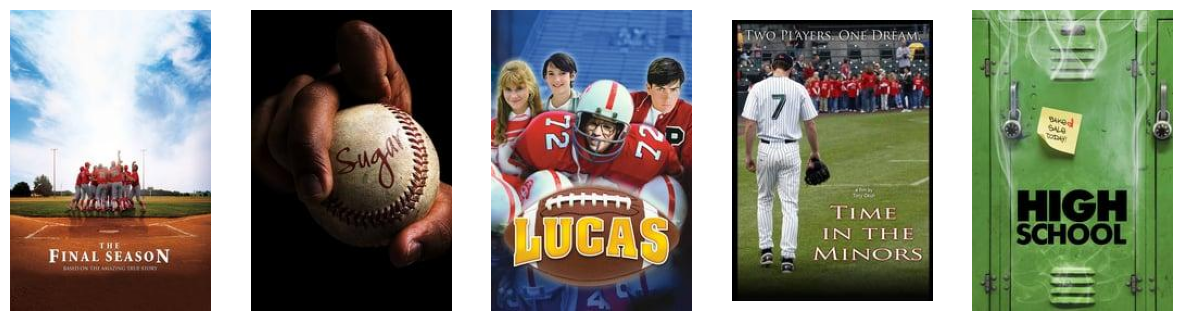

In [67]:
image=Image.open(image_paths[10])
query_image = preprocess(image).unsqueeze(0).to(device)
plt.imshow(image)

with torch.no_grad():
    q_emb = model.encode_image(query_image)
    q_emb = q_emb / q_emb.norm(dim=1, keepdim=True)

q_emb = q_emb.cpu().numpy()[0]

results = index.get_nns_by_vector(q_emb, 5)

plt.figure(figsize=(15, 4))
for i, idx in enumerate(results):
    plt.subplot(1, 5, i+1)
    plt.imshow(Image.open(image_paths[idx]))
    plt.axis("off")
plt.show()



Note that our approach here using CLIP leads to a more semantic understanding of 'close images' compared to other models.  
Try for instance to compare the images obtained when computing the similarity between representations obtrained with a classifier trained on the ImageNet dataset (like the one below for instance).

In [ ]:
import torchvision.models as models
mobilenet = models.mobilenet_v3_small(pretrained=True)
model = torch.nn.Sequential(mobilenet.features, mobilenet.avgpool, torch.nn.Flatten()).cuda().eval()